In [1]:
# DATA CLEANING AND PREPARATION STAGE (PANDAS)

import pandas as pd

df = pd.read_csv("imdb_top_1000.csv")

print(df.head(1)) # the first lines
print(df.shape) # number of rows and columns
print(df.columns) # sütun isimleri (column names)
print(df.info())
print(
    "\n The number of missing values \n", df.isna().sum()
)

df.columns = df.columns.str.strip() # Clear unnecessary gaps and format errors

# Fill missing values in the "Certificate" column with "unknown"
df["Certificate"] = df["Certificate"].fillna(
    "unknown"
)

# Fill missing values with the median of the column
df["Meta_score"] = df["Meta_score"].fillna(
    df["Meta_score"].median() # is preferred not to be affected by outlier values (Meta_score = 0-100)
)

# Convert the "Gross" column to numbers (remove commas, replace missing values with 0)
df["Gross"] = df["Gross"].astype(str).str.replace(",", "").astype(float) # Remove commas and convert to float
df["Gross"] = df["Gross"].fillna(
    df["Gross"].median()
)

# object -> numeric and setting errors to NaN
df["Released_Year"] = pd.to_numeric( # Convert to numeric
    df["Released_Year"],
    errors="coerce" # If conversion fails, set as NaN
)

# Filling NaN's with the average
mean_year = df["Released_Year"].mean()
df["Released_Year"] = df["Released_Year"].fillna(
    mean_year
)

# numeric -> int
df.Released_Year = df.Released_Year.astype('int64')

# object -> category
colomuns = ["Certificate", "Genre", "Director"]
for i in colomuns:
    df[i] = df[i].astype("category")

# object -> string -> int
df["Runtime"] = df["Runtime"].astype(str).str.replace(" min", "").astype('int64')

print(
    "\nAfter cleaning, data info:\n", df.dtypes
)
print(
    "\n The number of missing values \n", df.isna().sum()
)

                                         Poster_Link  \
0  https://m.media-amazon.com/images/M/MV5BMDFkYT...   

               Series_Title Released_Year Certificate  Runtime  Genre  \
0  The Shawshank Redemption          1994           A  142 min  Drama   

   IMDB_Rating                                           Overview  Meta_score  \
0          9.3  Two imprisoned men bond over a number of years...        80.0   

         Director        Star1           Star2       Star3           Star4  \
0  Frank Darabont  Tim Robbins  Morgan Freeman  Bob Gunton  William Sadler   

   No_of_Votes       Gross  
0      2343110  28,341,469  
(1000, 16)
Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   


Decision Tree Model Results:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       150
           1       0.61      0.72      0.66        50

    accuracy                           0.81       200
   macro avg       0.76      0.78      0.77       200
weighted avg       0.83      0.81      0.82       200



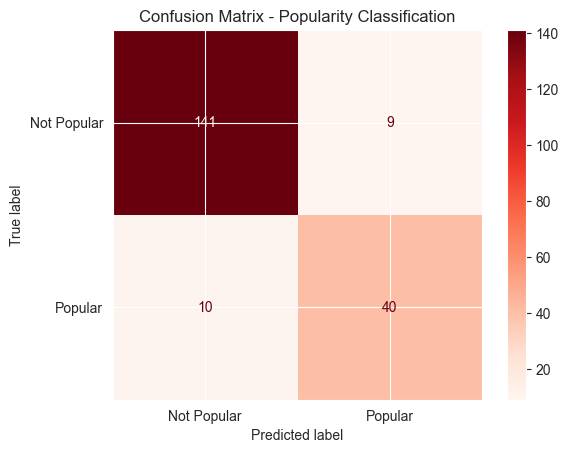

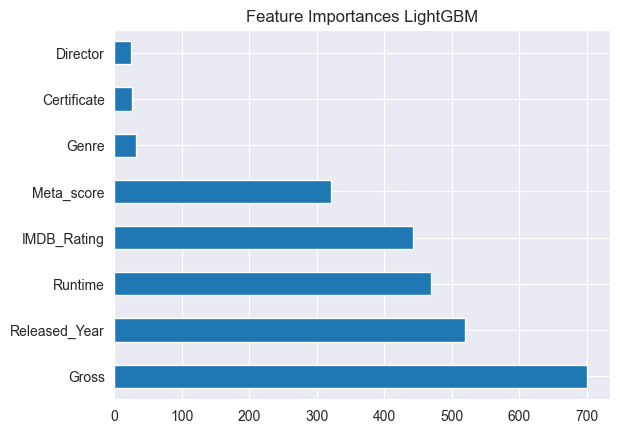


LightGBM Model Results:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       150
           1       0.82      0.80      0.81        50

    accuracy                           0.91       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.90      0.91      0.90       200



In [2]:
# BINARY CLASSIFICATION popular_or_not

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier

# Creating Target Variable (Hedef Sütunu Oluşturma)
treshold = df["No_of_Votes"].quantile(0.75)
df["popular_or_not"] = ( # %75’lik dilimin üstündeki veya eşit olanlar → 1 popüler / altındakiler → 0 popüler değil
    df["No_of_Votes"] >= treshold
).astype(int)

# Selecting Features
numeric_features = [
    "IMDB_Rating", "Meta_score", "Gross", "Runtime", "Released_Year"
]
x = df[numeric_features]
y = df["popular_or_not"]

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2, # Veri setinin %20’si modeli değerlendirmek (test etmek) için kullanılır / kalanı modeli eğitmek için
    random_state=42,
    stratify=y # Dengesiz veride yanlış öğrenmeyi önler
)

# Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight="balanced")
dt_model.fit(x_train, y_train) # model X_train'in içindeki özelliklerle y_train arasındaki ilişkiyi öğrenir
y_pred_dt = dt_model.predict(x_test) # y_pred_dt = modelin tahmin ettikleri / .predict(x_test) → model x_test'deki özellikleri kullanarak tahmin eder

print("\nDecision Tree Model Results:")
print(
    classification_report(y_test, y_pred_dt)
)

# To Inculede Categorical Features
categorical_features = ["Genre", "Certificate", "Director"]

# New X Matrix
x_full = df[numeric_features + categorical_features]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    x_full, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# LightGBM Model
lgbm = LGBMClassifier(
    max_depth=8,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train_f, y_train_f)

y_pred_lgbm = lgbm.predict(X_test_f)
LGBMClassifier(force_col_wise=True)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Popular", "Popular"]
)
disp.plot(cmap="Reds")
plt.title("Confusion Matrix - Popularity Classification")
plt.show()

# Feature Importance Graph
importances = pd.Series( # pd.Series = Etiketli veri taşır hangi değer hangi özelliğe ait, görebilirsin / Kolay sıralanır, filtrelenir
    lgbm.feature_importances_,
    index=X_train_f.columns
)
importances.nlargest(10).plot(kind="barh")
plt.title("Feature Importances LightGBM")
plt.show()

print("\nLightGBM Model Results:")
print(
    classification_report(y_test_f, y_pred_lgbm)
)

Linear Regression R²: 0.61
Linear Regression RMSE: 182200

Decision Tree R²: 0.66
Decision Tree RMSE: 170326.87


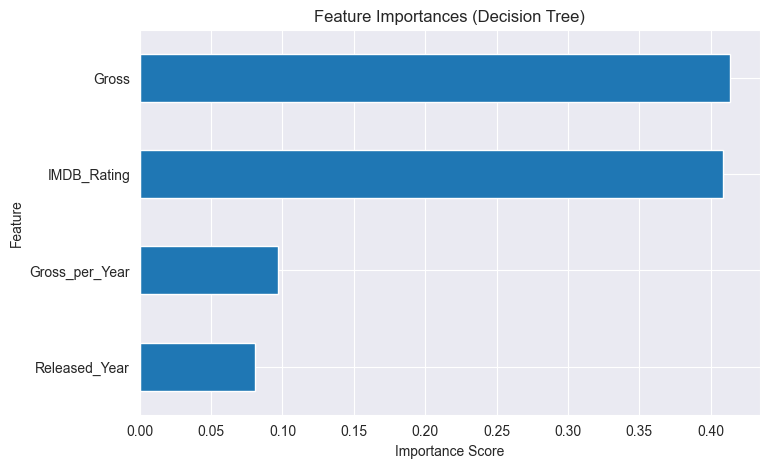

In [3]:
# PREDİCT POPULARİTY LEVEL OF MOVİES (Regression)

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Feature Engineering for Improving Model Performance
df["Gross_per_Year"] = df["Gross"] / (2025 - df["Released_Year"] + 1)

# Target Variable
y = df["No_of_Votes"]

# Independent Variables
X = df[
    [
        "IMDB_Rating", "Gross", "Released_Year", "Gross_per_Year"
    ]
]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(
    "Linear Regression R²:",
    round(
        r2_score( # fonksiyon R² (R-kare) değerini hesaplar / değer 1'e yakın model başarılı demektir
        y_test, y_pred_lr
        ), 2
    )
)

print(
    "Linear Regression RMSE:",
    round(
        rmse_lr, # Bu metrik, tahminlerin gerçek değerlere ne kadar uzak olduğunu ölçer / 0'a yakın olması modelin başarısını göster
    )
)

# Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)

print(
    "\nDecision Tree R²:",
    round(
        r2_score(y_test, y_pred_tree), 2
    )
)
print(
    "Decision Tree RMSE:",
    round(rmse_tree, 2)
)

# Feature Importance Graph
importances = pd.Series(tree.feature_importances_, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh')
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       143
           1       0.68      0.60      0.64        57

    accuracy                           0.81       200
   macro avg       0.76      0.74      0.75       200
weighted avg       0.80      0.81      0.80       200



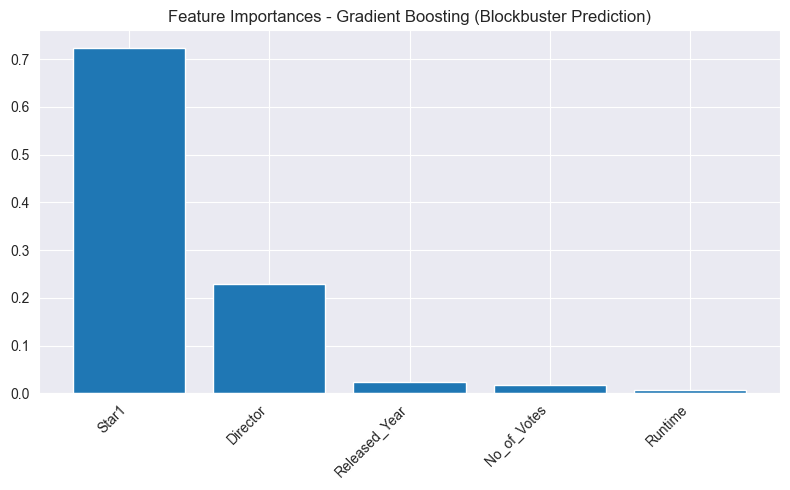

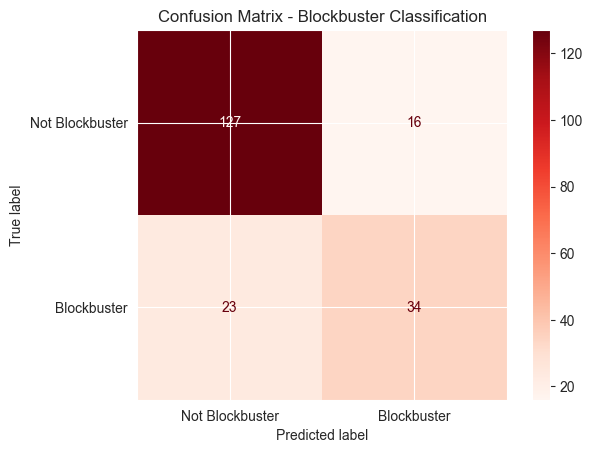

In [4]:
# CLASSIFICATION WITH GradientBoostingClassifier (is_blockbuster or not)

from sklearn.ensemble import GradientBoostingClassifier
from category_encoders import TargetEncoder

df["is_blockbuster"] = (df["Gross"] >= 50_000_000).astype(int)

features = [
    "Runtime",
    "Released_Year",
    "Director",
    "Star1",
    "No_of_Votes"
]

X = df[features].copy() # DataFrame’in bir kopyasını oluşturur, yani X üzerinde yapılan değişiklikler df’yi etkilemez
y = df["is_blockbuster"]

# Train-Test Split (before TargetEncoder)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Director + Star1 → TargetEncoder (fit only on train)
target_enc = TargetEncoder(cols=["Director", "Star1"])
X_train[["Director", "Star1"]] = target_enc.fit_transform(X_train[["Director", "Star1"]], y_train)
X_test[["Director", "Star1"]] = target_enc.transform(X_test[["Director", "Star1"]])

# Train the Model
gb = GradientBoostingClassifier(random_state=42, max_depth=6, learning_rate=0.1, n_estimators=500)
gb.fit(X_train, y_train)

# Evaluate the Model
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance Visualization
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=45, ha='right')
plt.title("Feature Importances - Gradient Boosting (Blockbuster Prediction)")
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Blockbuster", "Blockbuster"]
)
disp.plot(cmap="Reds")
plt.title("Confusion Matrix - Blockbuster Classification")
plt.show()


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       143
           1       0.70      0.67      0.68        57

    accuracy                           0.82       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.82      0.82      0.82       200



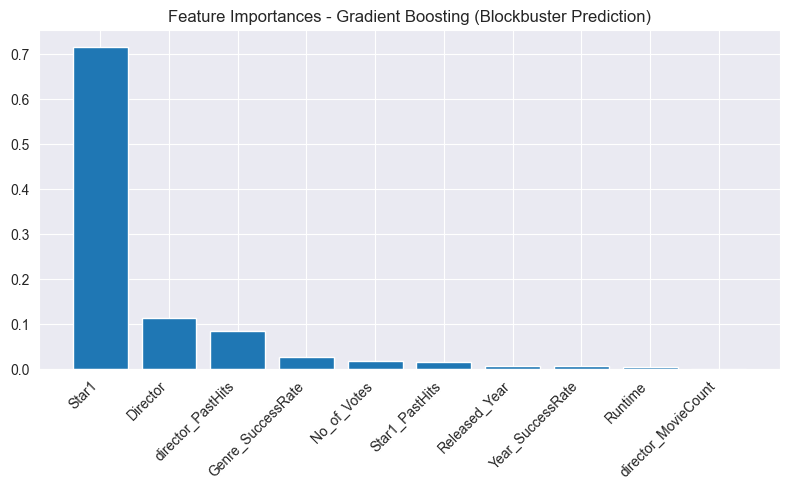

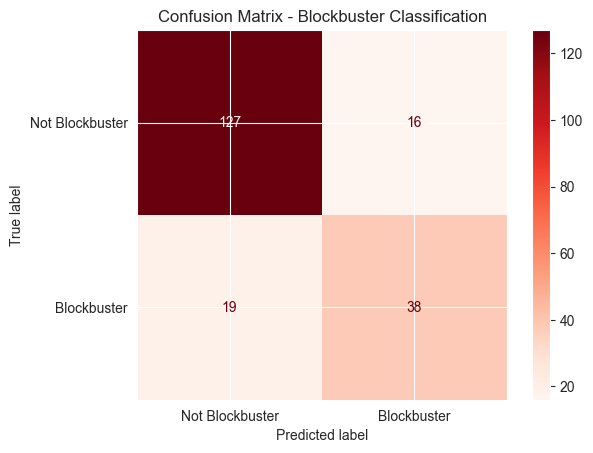

In [5]:
# CLASSIFICATION WITH GradientBoostingClassifier (is_blockbuster or not)

from sklearn.ensemble import GradientBoostingClassifier
from category_encoders import TargetEncoder

df["is_blockbuster"] = (df["Gross"] >= 50_000_000).astype(int)

features = [
    "Runtime",
    "Released_Year",
    "Director",
    "No_of_Votes",
    "Star1"
]

X = df[features].copy()
y = df["is_blockbuster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature Engineering Part

# Genre-based success rate
genre_success = (
    pd.DataFrame({"Genre": df.loc[X_train.index, "Genre"], "is_blockbuster": y_train})
    .groupby("Genre", observed=True)["is_blockbuster"]
    .mean()
    .to_dict()
)
X_train["Genre_SuccessRate"] = df.loc[X_train.index, "Genre"].map(genre_success)
X_test["Genre_SuccessRate"] = df.loc[X_test.index, "Genre"].map(genre_success)

# Year-based success rate
year_success = (
    pd.DataFrame({"Released_Year": X_train["Released_Year"], "is_blockbuster": y_train})
    .groupby("Released_Year")["is_blockbuster"]
    .mean()
    .to_dict()
)
X_train["Year_SuccessRate"] = X_train["Released_Year"].map(year_success)
X_test["Year_SuccessRate"] = X_test["Released_Year"].map(year_success)

# Number of blockbusters is calculated according to players in the Train data
star1_past_hits = (
    pd.DataFrame({"Star1": df.loc[X_train.index, "Star1"], "is_blockbuster": y_train})
    .groupby("Star1")["is_blockbuster"]
    .sum()
    .to_dict()
)
X_train["Star1_PastHits"] = df.loc[X_train.index, "Star1"].map(star1_past_hits)
X_test["Star1_PastHits"] = df.loc[X_test.index, "Star1"].map(star1_past_hits)

# Director Past Hits
director_past_hits = (
    pd.DataFrame({"Director": df.loc[X_train.index, "Director"], "is_blockbuster": y_train})
    .groupby("Director", observed=True)["is_blockbuster"]
    .sum()
    .to_dict()
)
X_train["director_PastHits"] = df.loc[X_train.index, "Director"].map(director_past_hits)
X_test["director_PastHits"] = df.loc[X_test.index, "Director"].map(director_past_hits)

# Director Movie Count
director_movie_count = (
    pd.DataFrame({"Director": df.loc[X_train.index, "Director"], "Series_Title": df.loc[X_train.index, "Series_Title"]})
    .groupby("Director", observed=True)["Series_Title"]
    .count()
    .to_dict()
)
X_train["director_MovieCount"] = df.loc[X_train.index, "Director"].map(director_movie_count)
X_test["director_MovieCount"] = df.loc[X_test.index, "Director"].map(director_movie_count)

# Target Encoding for Director and Star1
target_enc = TargetEncoder(cols=["Director", "Star1"])
X_train[["Director", "Star1"]] = target_enc.fit_transform(X_train[["Director", "Star1"]], y_train)
X_test[["Director", "Star1"]] = target_enc.transform(X_test[["Director", "Star1"]])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

gb = GradientBoostingClassifier(
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500
)
gb.fit(X_train, y_train)

# Model Değerlendirmesi
y_pred = gb.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=45, ha='right')
plt.title("Feature Importances - Gradient Boosting (Blockbuster Prediction)")
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Blockbuster", "Blockbuster"]
)
disp.plot(cmap="Reds")
plt.title("Confusion Matrix - Blockbuster Classification")
plt.show()


In [6]:
# En Çok Hasılata Sahip ilk 20 Film
top60 = df.nlargest(60, 'Gross')  # 'Gross' hasılat sütunu
print(top60['Genre'])

star_columns = ["Director"]

# Her sütunu kontrol et
for col in star_columns:
    duplicates = df[df[col].duplicated(keep=False)]  # Aynı isim birden fazla varsa
    if not duplicates.empty:
        print(f"\n🔁 {col} sütununda tekrar eden isim(ler) bulundu:")
        for name in duplicates[col].unique():
            indexler = df.index[df[col] == name].tolist()
            print(f"  - '{name}' ismi indexlerde: {indexler}")
    else:
        print(f"\n✅ {col} sütununda tekrar eden isim yok.")

477       Action, Adventure, Sci-Fi
59         Action, Adventure, Drama
623      Action, Adventure, Fantasy
60        Action, Adventure, Sci-Fi
652                  Drama, Romance
357       Action, Adventure, Sci-Fi
891    Animation, Action, Adventure
2              Action, Crime, Drama
582       Action, Adventure, Sci-Fi
63                Action, Adventure
688                  Family, Sci-Fi
596    Animation, Adventure, Comedy
43      Animation, Adventure, Drama
151    Animation, Adventure, Comedy
583       Action, Adventure, Sci-Fi
262       Action, Adventure, Sci-Fi
887       Action, Adventure, Comedy
226       Adventure, Drama, Fantasy
242    Animation, Adventure, Comedy
5          Action, Adventure, Drama
348       Action, Adventure, Comedy
213    Animation, Adventure, Comedy
13         Action, Adventure, Drama
330    Animation, Adventure, Comedy
33           Crime, Drama, Thriller
339       Action, Adventure, Comedy
11                   Drama, Romance
722       Action, Adventure,